# 1.7e: Perturbation Test

This notebook tests how cluster token logits respond to reference vectors that point **near** (but not exactly at) the cluster centroid.

## The Question

In 1.7c, we proved that cluster tokens are perfectly degenerate when pointing at PC1 (all 2,212 tokens get identical logit = 0.308594).

But what happens when we point **near** the cluster instead of directly at it?

**Two possible outcomes:**

1. **Cluster is truly degenerate:** Tokens remain indistinguishable even from nearby angles
   - Logits stay tightly bunched (maybe ~134 discrete values corresponding to black holes)
   - Histogram shows spikes at populations 814, 704, 306, etc.
   - As we move away, spikes broaden but remain visible

2. **Cluster has internal structure:** Tokens spread out when viewed from nearby angles
   - Logits develop smooth distribution
   - Histogram becomes continuous (no black hole spikes)
   - Cluster looks "normal"

## Method

1. Load cluster centroid from 1.6a reference frame
2. Construct query vector: **h = centroid + σ × randn()**
3. Normalize and convert to bfloat16
4. Compute logits = W @ h in bfloat16
5. Visualize:
   - Sorted logit plot: ALL tokens, cluster highlighted in red
   - Histogram: ALL logits with zoom capability

**Key parameters:**
- **SIGMA**: Perturbation scale (0 = exact centroid, >0 = add noise)
- **HIST_X_MIN, HIST_X_MAX**: Zoom window for histogram

## Parameters

In [67]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Perturbation scale
SIGMA = 0.0  # 0 = point exactly at centroid, >0 = add noise

# Random seed for reproducibility
RANDOM_SEED = 42

# Histogram zoom window (set to None for full range)
HIST_X_MIN = 0.35  # e.g., 0.30 to zoom into cluster region
HIST_X_MAX = 0.40  # e.g., 0.32 to zoom into cluster region
# HIST_X_MIN = 0.370912  # Zoom into cluster region
# HIST_X_MAX = 0.370922

# Histogram bins
NUM_BINS = 200  # Number of bins in visible range

# Visualization
FIGSIZE_SORTED = (16, 8)
FIGSIZE_HIST = (16, 8)
DPI = 150

## Imports

In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Device Detection

In [69]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Unembedding Matrix (bfloat16)

In [70]:
# Load W in bfloat16 (as the model actually uses it)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W = load_file(tensor_path)["W"].to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")
print(f"  dtype: {W.dtype}")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions
  dtype: torch.bfloat16


## Load Cluster Centroid

In [71]:
# Load precomputed cluster centroid from 1.6a
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
centroid = ref_data['cluster_centroid'].to(device)

print(f"\nLoaded cluster centroid")
print(f"  Shape: {centroid.shape}")
print(f"  Norm: {torch.linalg.vector_norm(centroid.float()).item():.6f}")


Loaded cluster centroid
  Shape: torch.Size([2560])
  Norm: 0.370917


## Load Cluster Tokens

In [72]:
# Load cluster tokens from 1.4h
cluster_path = Path(f"../tensors/{MODEL_NAME}/1.4h_cluster_tokens.safetensors")
cluster_data = load_file(cluster_path)
cluster_token_ids = cluster_data['cluster_token_ids'].to(device)

print(f"\nLoaded {len(cluster_token_ids):,} cluster token IDs")
print(f"  Token ID range: [{cluster_token_ids.min().item()}, {cluster_token_ids.max().item()}]")


Loaded 2,212 cluster token IDs
  Token ID range: [124, 151935]


## Construct Query Vector

In [73]:
print(f"\n{'='*70}")
print("CONSTRUCTING QUERY VECTOR")
print(f"{'='*70}\n")

print(f"Perturbation scale (SIGMA): {SIGMA}")

# Start with cluster centroid
if SIGMA > 0:
    # Add Gaussian perturbation
    perturbation = torch.randn_like(centroid) * SIGMA
    h = centroid + perturbation
    print(f"  Added perturbation with std={SIGMA}")
else:
    # Point exactly at centroid
    h = centroid.clone()
    print(f"  Pointing exactly at centroid (no perturbation)")

# Normalize to unit length
h = h / torch.linalg.vector_norm(h)

# Convert to bfloat16
h = h.to(torch.bfloat16)

print(f"\nQuery vector:")
print(f"  Shape: {h.shape}")
print(f"  dtype: {h.dtype}")
print(f"  Norm: {torch.linalg.vector_norm(h.float()).item():.6f}")

# Compute cosine similarity with original centroid
centroid_normalized = centroid / torch.linalg.vector_norm(centroid)
h_f32 = h.float()
cosine_sim = torch.dot(h_f32, centroid_normalized.float()).item()
print(f"  Cosine similarity with centroid: {cosine_sim:.6f}")


CONSTRUCTING QUERY VECTOR

Perturbation scale (SIGMA): 0.0
  Pointing exactly at centroid (no perturbation)

Query vector:
  Shape: torch.Size([2560])
  dtype: torch.bfloat16
  Norm: 0.999835
  Cosine similarity with centroid: 0.999833


## Compute Logits (bfloat16)

In [74]:
print(f"\n{'='*70}")
print("COMPUTING LOGITS IN BFLOAT16")
print(f"{'='*70}\n")

# Compute logits: dot product with all tokens
print(f"Computing logits = W @ h...")
logits = W @ h
print(f"✓ Logits computed: {logits.shape}")
print(f"  dtype: {logits.dtype}")

# Convert to float32 for statistics (but keep bfloat16 values)
logits_f32 = logits.float()

# Statistics for all tokens
print(f"\nLogit distribution (all {N:,} tokens):")
print(f"  Max: {logits_f32.max().item():.10f}")
print(f"  Min: {logits_f32.min().item():.10f}")
print(f"  Mean: {logits_f32.mean().item():.10f}")
print(f"  Median: {logits_f32.median().item():.10f}")
print(f"  Std: {logits_f32.std().item():.10f}")
print(f"  Range: {(logits_f32.max() - logits_f32.min()).item():.10f}")


COMPUTING LOGITS IN BFLOAT16

Computing logits = W @ h...
✓ Logits computed: torch.Size([151936])
  dtype: torch.bfloat16

Logit distribution (all 151,936 tokens):
  Max: 0.6289062500
  Min: -0.6835937500
  Mean: 0.2734605074
  Median: 0.2890625000
  Std: 0.0867542848
  Range: 1.3125000000


## Sort and Separate Populations

In [75]:
print(f"\n{'='*70}")
print("SORTING AND SEPARATING POPULATIONS")
print(f"{'='*70}\n")

# Sort logits (descending) and get token indices
sorted_logits, sorted_indices = torch.sort(logits_f32, descending=True)
sorted_logits_np = sorted_logits.cpu().numpy()
sorted_indices_np = sorted_indices.cpu().numpy()

# Create set for fast membership checking
cluster_token_set = set(cluster_token_ids.cpu().numpy())

# Determine which sorted tokens are in cluster
is_cluster = np.array([idx in cluster_token_set for idx in sorted_indices_np])

# Separate into cluster and non-cluster
cluster_ranks = np.where(is_cluster)[0]
non_cluster_ranks = np.where(~is_cluster)[0]

cluster_logits_sorted = sorted_logits_np[cluster_ranks]
non_cluster_logits_sorted = sorted_logits_np[non_cluster_ranks]

print(f"Sorted all {N:,} tokens by logit")
print(f"\nCluster tokens:")
print(f"  Count: {len(cluster_ranks):,}")
print(f"  Rank range: [{cluster_ranks.min()}, {cluster_ranks.max()}]")
print(f"  Logit range: [{cluster_logits_sorted.min():.10f}, {cluster_logits_sorted.max():.10f}]")
print(f"  Logit std: {cluster_logits_sorted.std():.10f}")

# Count unique logit values in cluster
cluster_logits_tensor = logits[cluster_token_ids].float()
unique_cluster_logits = torch.unique(cluster_logits_tensor)
print(f"  Unique values: {len(unique_cluster_logits)}")

print(f"\nNon-cluster tokens:")
print(f"  Count: {len(non_cluster_ranks):,}")


SORTING AND SEPARATING POPULATIONS

Sorted all 151,936 tokens by logit

Cluster tokens:
  Count: 2,212
  Rank range: [10365, 13346]
  Logit range: [0.3710937500, 0.3710937500]
  Logit std: 0.0000000000
  Unique values: 1

Non-cluster tokens:
  Count: 149,724


## Visualization 1: Sorted Logit Plot (All Tokens)


Creating sorted logit plot...



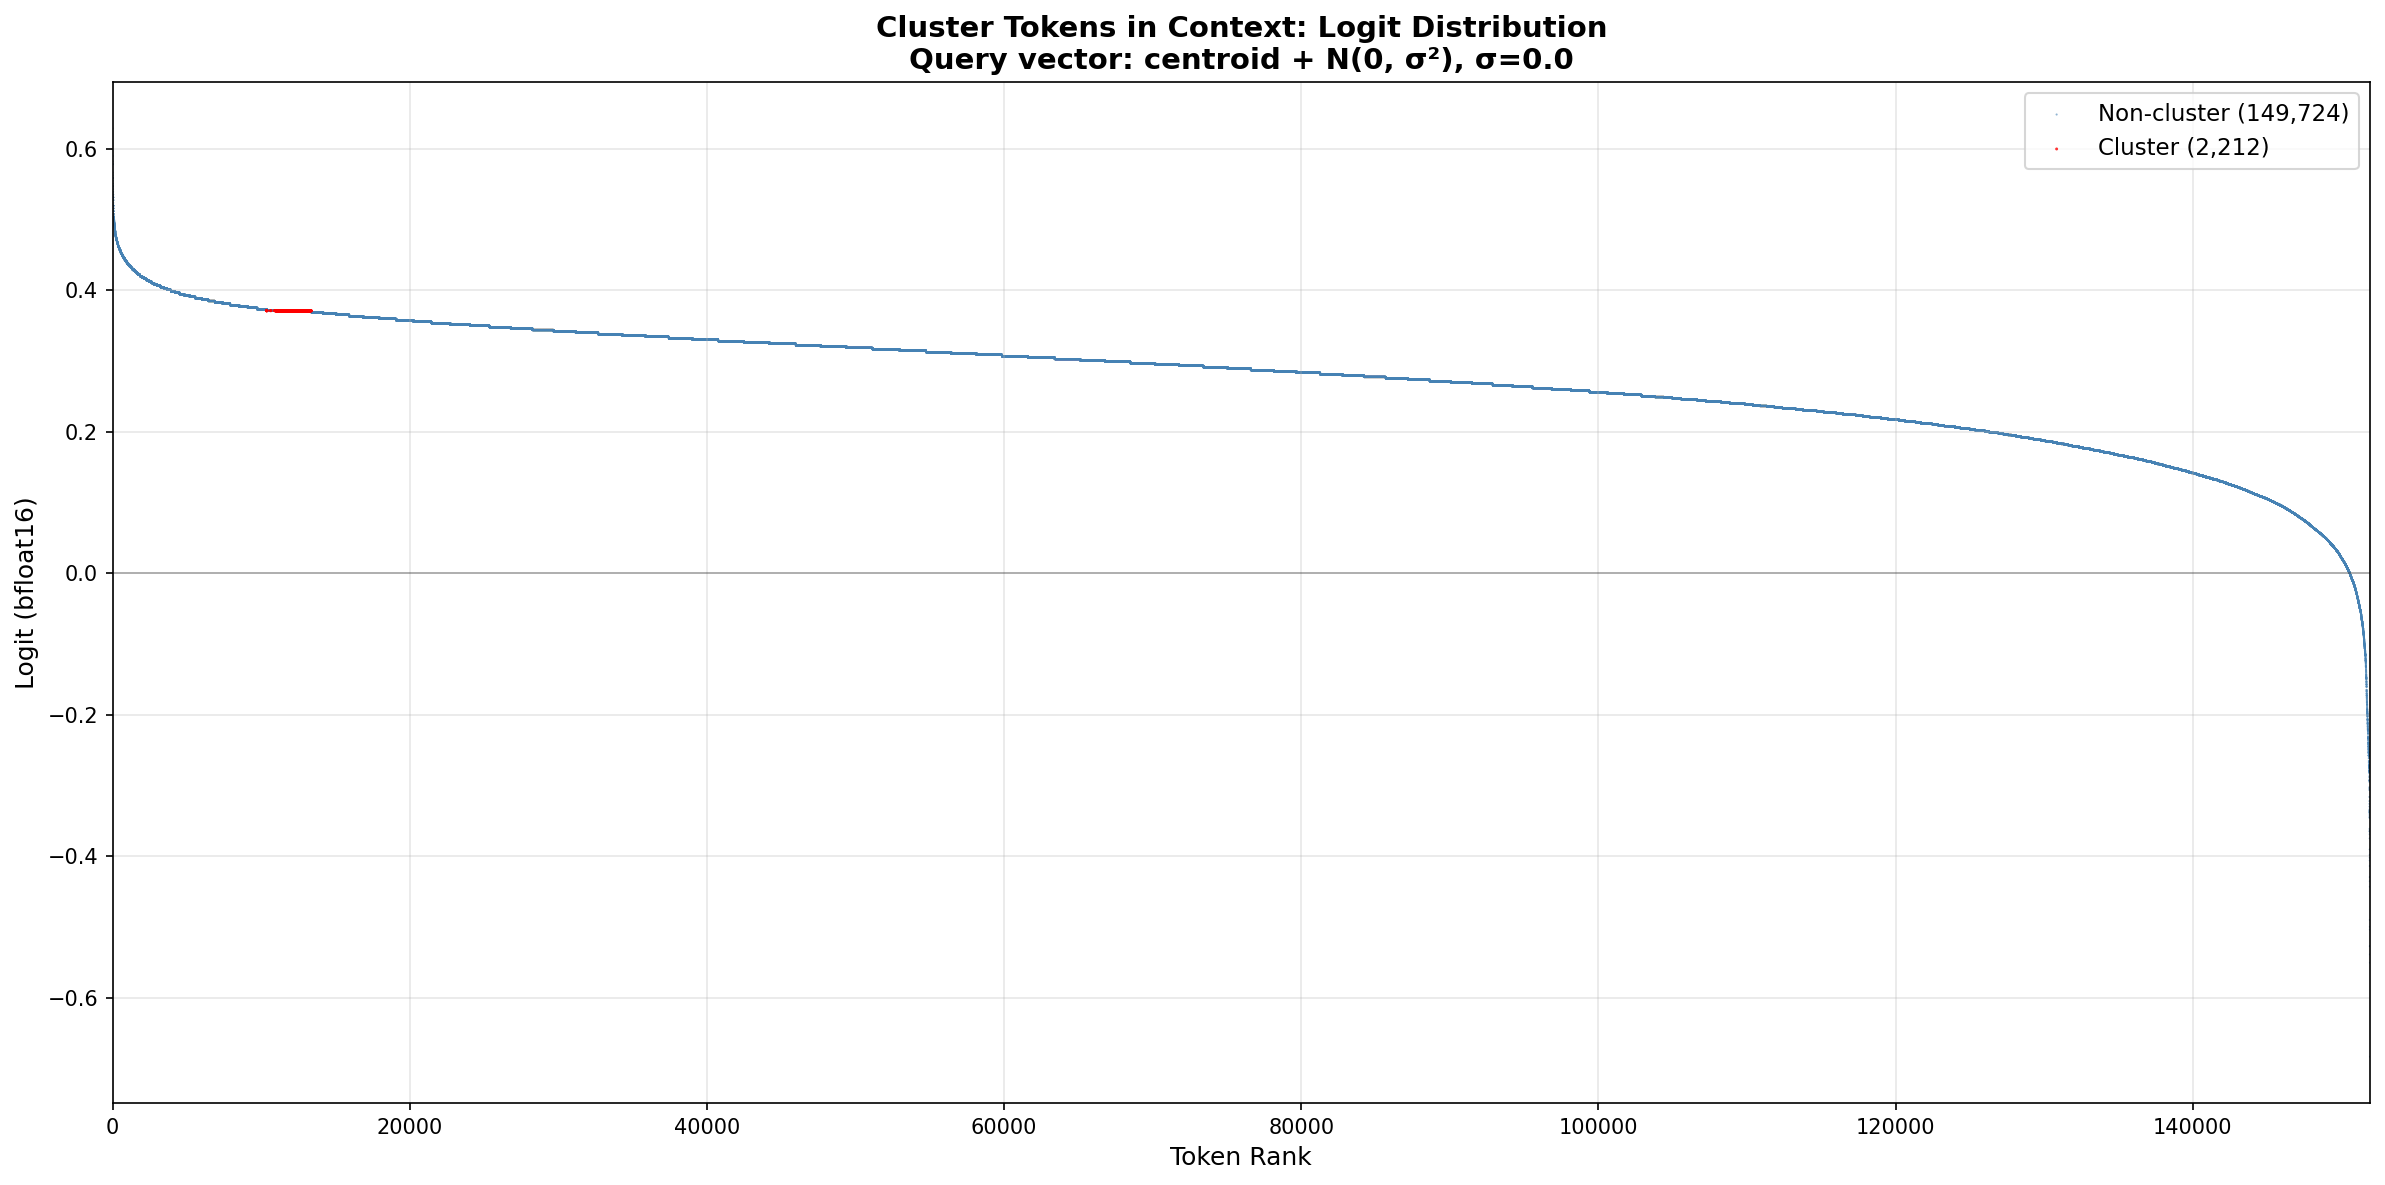

✓ Sorted logit plot complete


In [76]:
print(f"\nCreating sorted logit plot...\n")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE_SORTED, dpi=DPI)

# Plot non-cluster tokens (background)
ax.scatter(non_cluster_ranks, 
           non_cluster_logits_sorted,
           s=1.0, 
           alpha=0.6,
           color='steelblue',
           label=f'Non-cluster ({len(non_cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Plot cluster tokens (foreground)
ax.scatter(cluster_ranks, 
           cluster_logits_sorted,
           s=2.0, 
           alpha=0.8,
           color='red',
           label=f'Cluster ({len(cluster_ranks):,})',
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_xlabel('Token Rank', fontsize=12)
ax.set_ylabel('Logit (bfloat16)', fontsize=12)
ax.set_title(f'Cluster Tokens in Context: Logit Distribution\n' +
             f'Query vector: centroid + N(0, σ²), σ={SIGMA}',
             fontsize=14, fontweight='bold')
ax.set_xlim(0, N)
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
ax.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print(f"✓ Sorted logit plot complete")

## Visualization 2: Logit Histogram (All Tokens, with Zoom)


Creating logit histogram...

Histogram zoom enabled:
  X range: [0.35, 0.4]
  Visible tokens: 20,124 / 151,936 (13.25%)


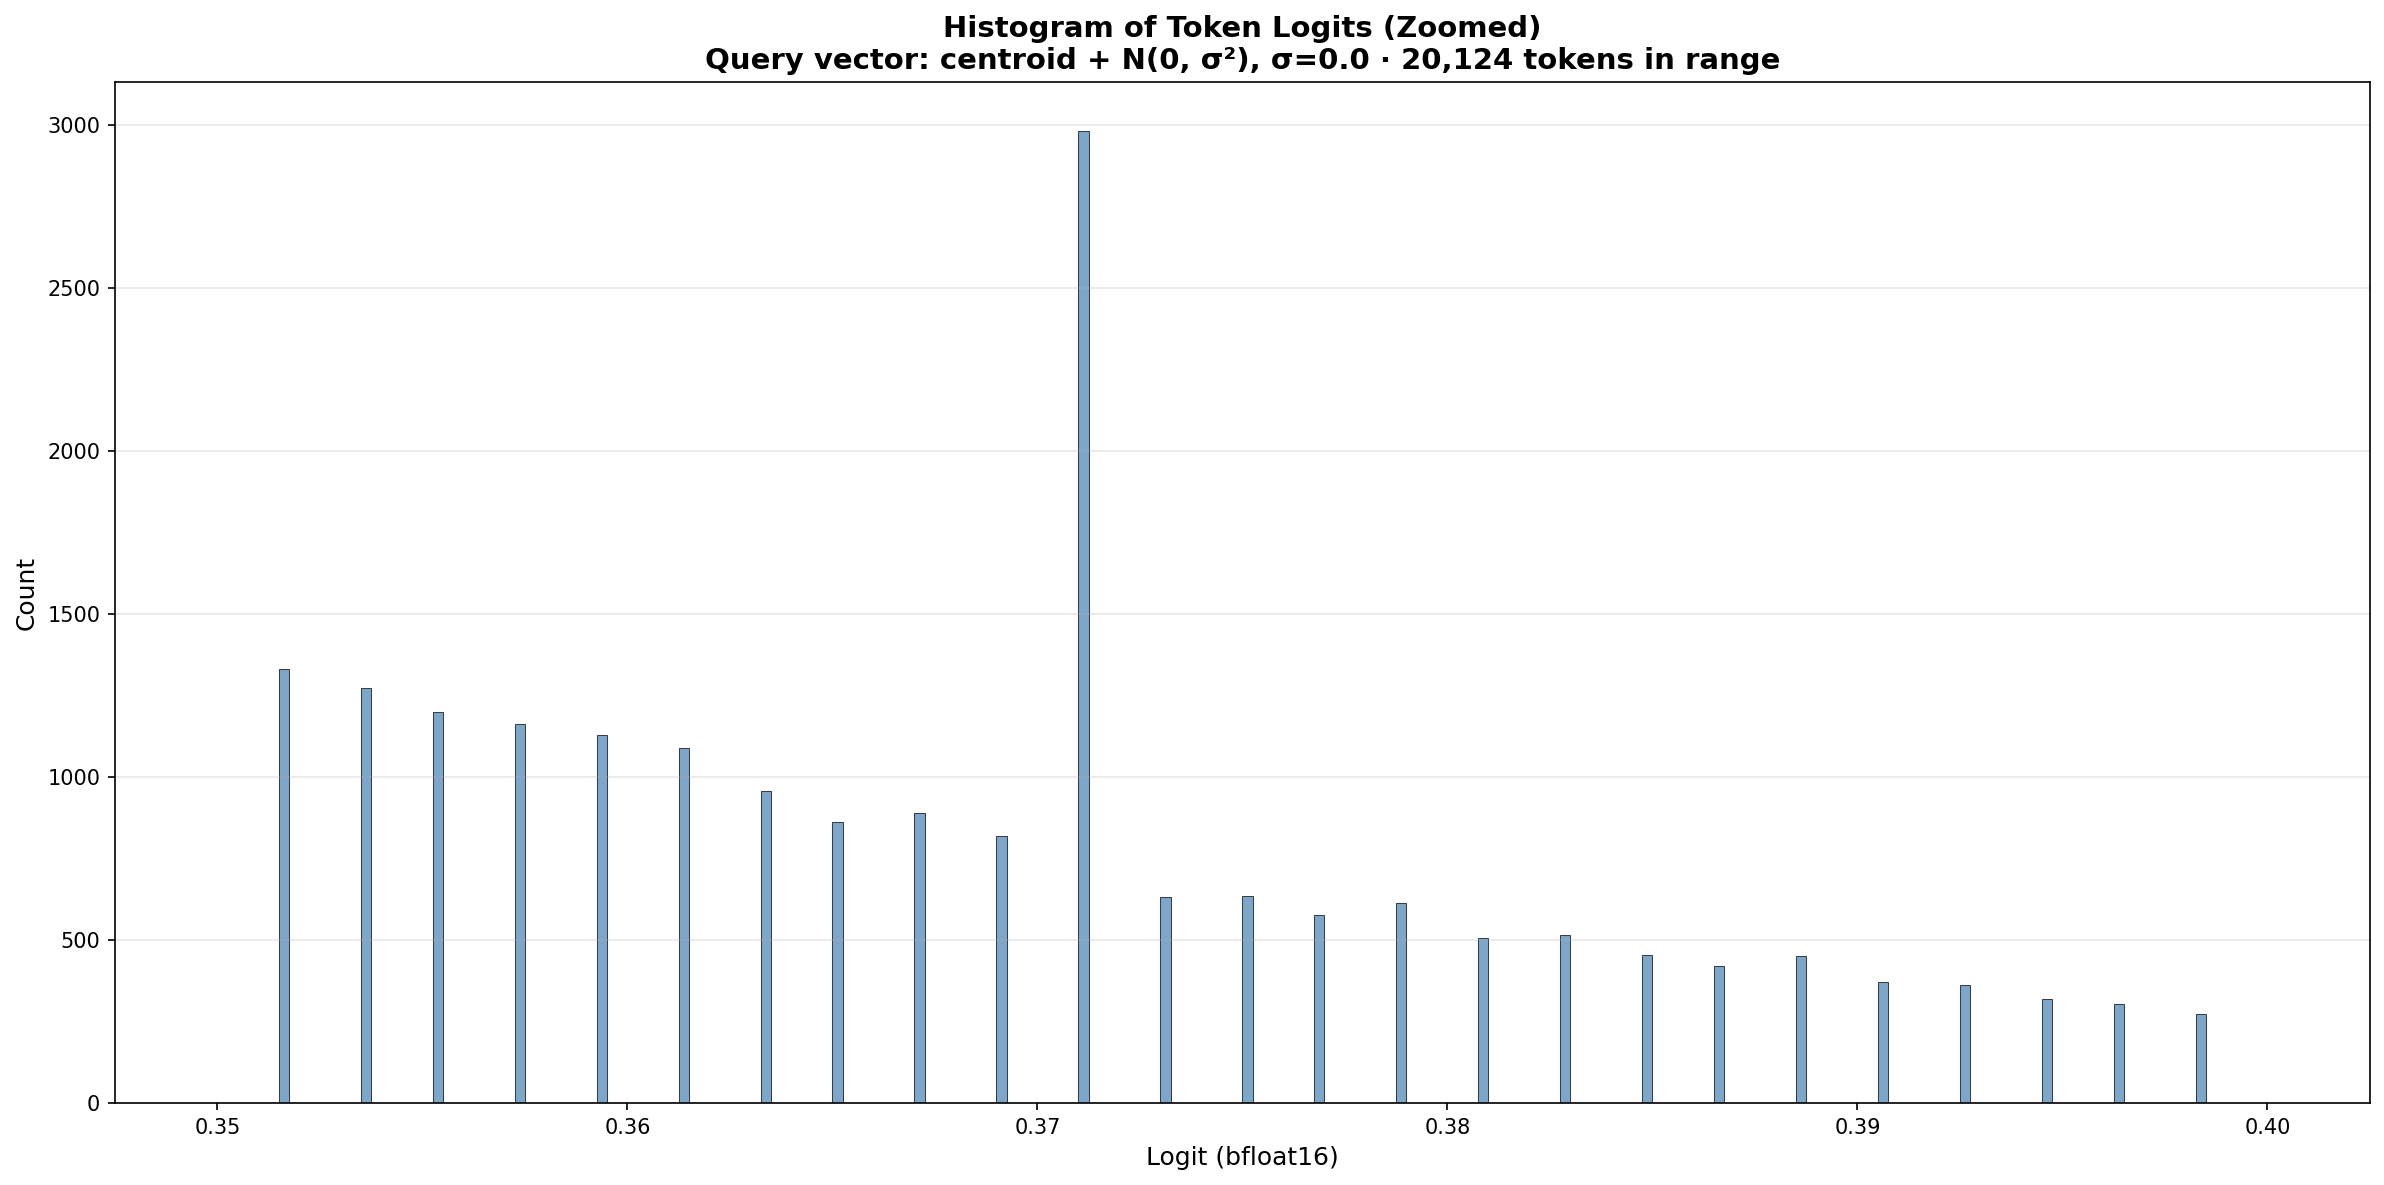


✓ Histogram complete

Histogram statistics:
  Bins: 200
  Bin width: 0.0002500117
  Max bin count: 2982
  Non-zero bins: 25/200


In [77]:
print(f"\nCreating logit histogram...\n")

# Get all logits as numpy
all_logits_np = logits_f32.cpu().numpy()

# Determine histogram range
if HIST_X_MIN is not None and HIST_X_MAX is not None:
    # Zoom mode: filter to visible range BEFORE binning
    mask = (all_logits_np >= HIST_X_MIN) & (all_logits_np <= HIST_X_MAX)
    visible_logits = all_logits_np[mask]
    hist_range = (HIST_X_MIN, HIST_X_MAX)
    print(f"Histogram zoom enabled:")
    print(f"  X range: [{HIST_X_MIN}, {HIST_X_MAX}]")
    print(f"  Visible tokens: {len(visible_logits):,} / {N:,} ({100*len(visible_logits)/N:.2f}%)")
else:
    # Full range mode
    visible_logits = all_logits_np
    hist_range = (all_logits_np.min(), all_logits_np.max())
    print(f"Histogram full range:")
    print(f"  X range: [{hist_range[0]:.6f}, {hist_range[1]:.6f}]")
    print(f"  All {N:,} tokens visible")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE_HIST, dpi=DPI)

# Histogram of visible logits
counts, bins, patches = ax.hist(visible_logits, 
                                 bins=NUM_BINS,
                                 range=hist_range,
                                 color='steelblue', 
                                 alpha=0.7, 
                                 edgecolor='black', 
                                 linewidth=0.5)

# Formatting
ax.set_xlabel('Logit (bfloat16)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

if HIST_X_MIN is not None and HIST_X_MAX is not None:
    title = f'Histogram of Token Logits (Zoomed)\n' + \
            f'Query vector: centroid + N(0, σ²), σ={SIGMA} · {len(visible_logits):,} tokens in range'
else:
    title = f'Histogram of Token Logits (Full Range)\n' + \
            f'Query vector: centroid + N(0, σ²), σ={SIGMA} · {N:,} tokens'

ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ Histogram complete")
print(f"\nHistogram statistics:")
print(f"  Bins: {NUM_BINS}")
print(f"  Bin width: {(bins[1] - bins[0]):.10f}")
print(f"  Max bin count: {counts.max():.0f}")
print(f"  Non-zero bins: {(counts > 0).sum()}/{NUM_BINS}")

## Summary

This notebook tests whether cluster tokens remain indistinguishable when viewed from angles near (but not exactly at) the cluster centroid.

**Expected results at σ=0 (pointing exactly at centroid):**

1. **Sorted plot:** Cluster tokens (red) should form tight horizontal band within blue S-curve
2. **Histogram (zoomed to cluster region):** Should reveal ~134 discrete spikes if cluster is truly degenerate
   - 13 black holes with populations: 814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2
   - 121 singletons with population: 1 each
   - Try: HIST_X_MIN = 0.30, HIST_X_MAX = 0.32 to zoom into cluster

**Expected results as σ increases:**

1. **Sorted plot:** Red band should develop vertical spread (cluster tokens separate)
2. **Histogram:** Spikes should broaden and merge into continuous distribution

**What this tells us:**

- **If histogram shows discrete spikes at σ=0:** Confirms black hole structure is visible in logit space
- **If spikes persist at small σ:** Cluster is truly degenerate (robust to small perturbations)
- **If spikes disappear at small σ:** Cluster has internal structure (sensitive to viewing angle)

**Suggested parameter sweeps:**

**SIGMA values to try:**
- 0.0 (exact centroid)
- 0.001 (tiny perturbation)
- 0.01 (small perturbation)
- 0.1 (large perturbation)

**Histogram zoom to try (at σ=0):**
- Full range: HIST_X_MIN = None, HIST_X_MAX = None
- Cluster region: HIST_X_MIN = 0.30, HIST_X_MAX = 0.32
- Tight zoom: HIST_X_MIN = 0.308, HIST_X_MAX = 0.309